In [20]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import numpy as np
from datetime import datetime
import xarray as xr
from xarray.backends import NetCDF4DataStore
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter

## Precipitable Water, 1000-700mb Winds

In [22]:
%%capture

VALID_TIME = '2022-08-07T0000'
PLEVEL1 = 1000
PLEVEL2 = 850
PLEVEL3 = 700

# Define area to plot
BOTTOM_LAT = 23
TOP_LAT = 40
LEFT_LON = -105
RIGHT_LON = -65

# Model Endpoints 
hrrr = 'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr20200722/hrrr_sfc.t12z'
arw = 'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw20200430/hiresw_conusarw_12z'
nbm = 'https://nomads.ncep.noaa.gov/dods/blend/blend20200417/blend_1hr_22z'
rap = 'https://nomads.ncep.noaa.gov/dods/rap/rap20210627/rap_09z'
gfs = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs20220806/gfs_0p25_06z'

base_url = gfs

ds = xr.open_dataset(base_url, decode_times=True)

# Take lat and lon slices
LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)

if base_url == gfs:
    LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)
else:
    LON_SLICE = slice(LEFT_LON, RIGHT_LON)
    
# Extract all lats, lons, and meteorological datasets to plot
lats = ds.lat.sel(lat=LAT_SLICE).values

if base_url == gfs:
    lons = ds.lon.sel(lon=LON_SLICE).values
else:
    lons = 360 + ds.lon.sel(lon=LON_SLICE).values
    
uwnd1 = gaussian_filter(ds.ugrdprs.sel(lat=LAT_SLICE, lon=LON_SLICE, lev=PLEVEL1, time=VALID_TIME),
                       sigma=3.0) * units('m/s')
vwnd1 = gaussian_filter(ds.vgrdprs.sel(lat=LAT_SLICE, lon=LON_SLICE, lev=PLEVEL1, time=VALID_TIME),
                       sigma=3.0) * units('m/s')

uwnd2 = gaussian_filter(ds.ugrdprs.sel(lat=LAT_SLICE, lon=LON_SLICE, lev=PLEVEL2, time=VALID_TIME),
                       sigma=3.0) * units('m/s')
vwnd2 = gaussian_filter(ds.vgrdprs.sel(lat=LAT_SLICE, lon=LON_SLICE, lev=PLEVEL2, time=VALID_TIME),
                       sigma=3.0) * units('m/s')

uwnd3 = gaussian_filter(ds.ugrdprs.sel(lat=LAT_SLICE, lon=LON_SLICE, lev=PLEVEL3, time=VALID_TIME),
                       sigma=3.0) * units('m/s')
vwnd3 = gaussian_filter(ds.vgrdprs.sel(lat=LAT_SLICE, lon=LON_SLICE, lev=PLEVEL3, time=VALID_TIME),
                       sigma=3.0) * units('m/s')

pwat = gaussian_filter(ds.pwatclm.sel(lat=LAT_SLICE, lon=LON_SLICE, time=VALID_TIME), sigma=2.0)


def convert_datetime_from_nomads_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

LOCAL_TIME = convert_datetime_from_nomads_to_local(VALID_TIME)

## Setup Basemap and Plot Data

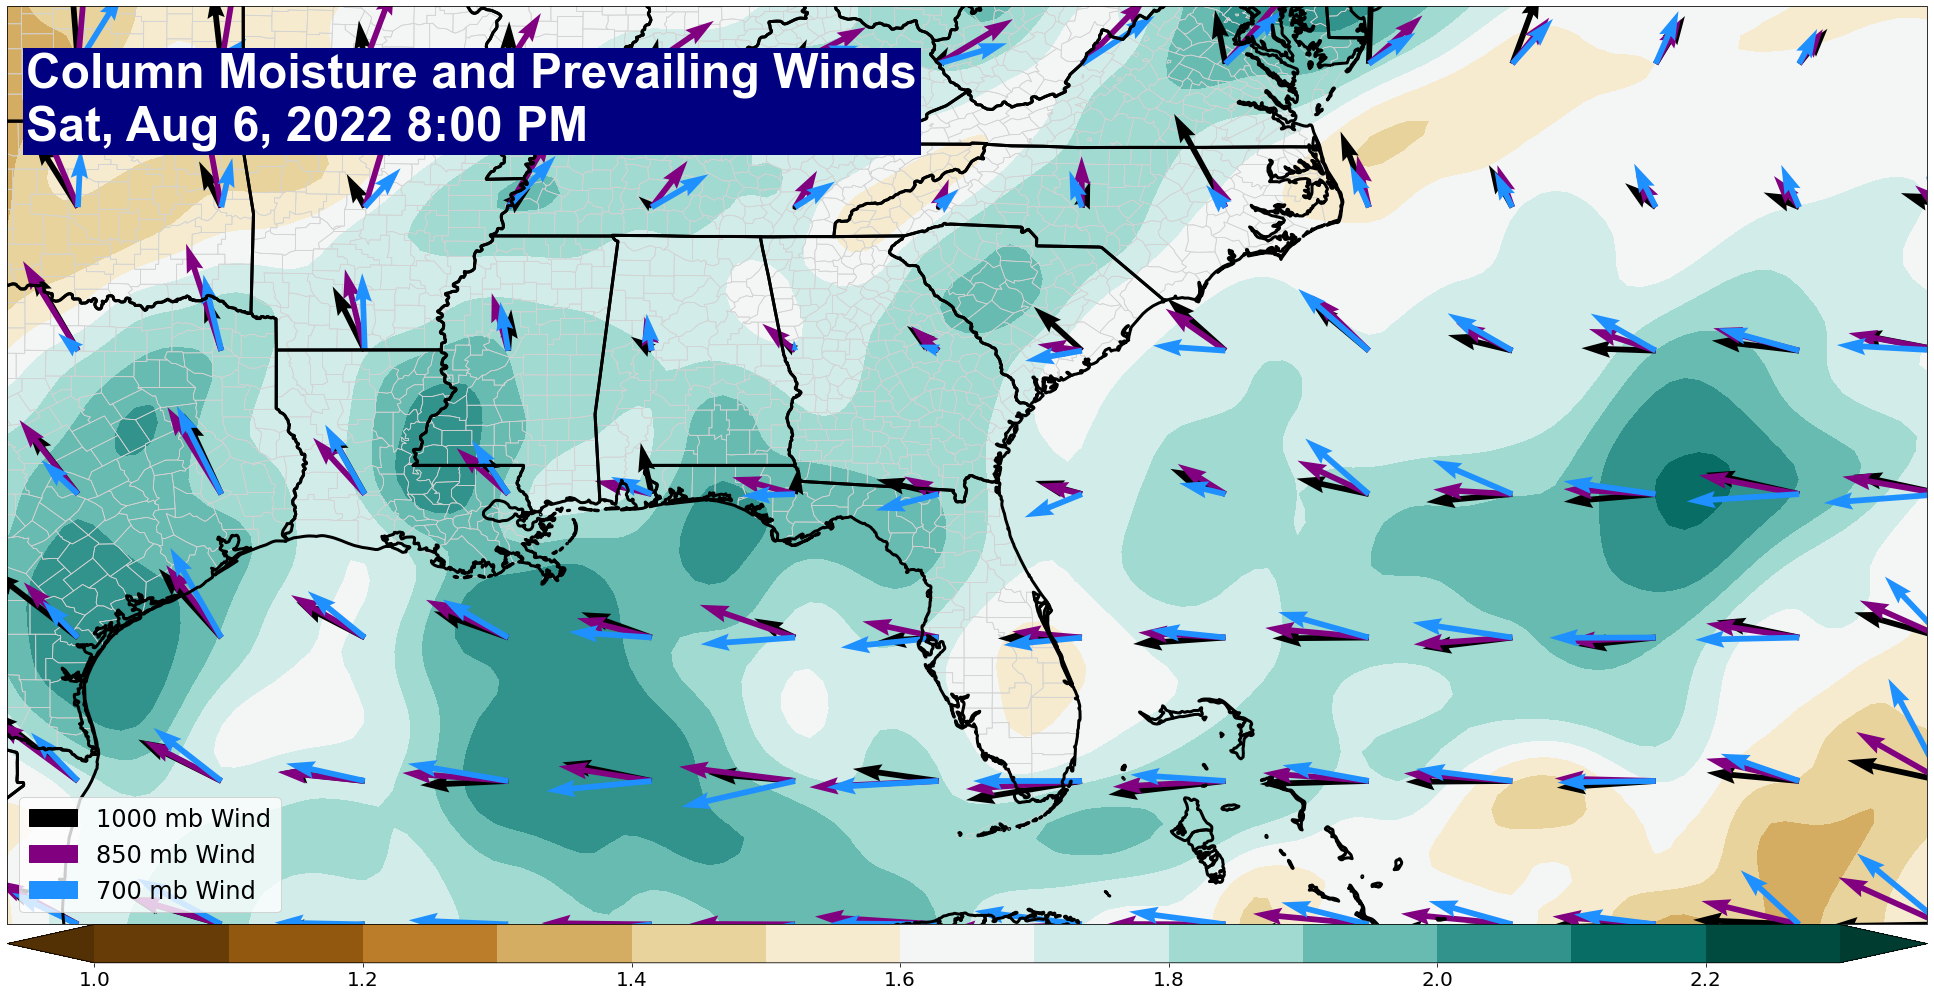

In [23]:
# Setup matplotlib figure
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', zorder=2, linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=3.00, zorder=3)
ax.set_extent([-89, -75, 23, 39])
ax.set_adjustable('datalim')

pwat_contour_values = np.arange(1.0, 2.4, 0.10)
contour_fill = ax.contourf(lons, lats, pwat / 25.4, pwat_contour_values,
                           cmap=plt.cm.BrBG, extend='both', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour_fill, orientation='horizontal', pad=0, aspect=50)
cbar.ax.tick_params(labelsize=20)

# Plot Wind Quivers
wind_slice = (slice(None, None, 10), slice(None, None, 10))

ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
          uwnd1[wind_slice].to('kt'), vwnd1[wind_slice].to('kt'), scale=300, width=0.003,
          color='black', zorder=2, transform=ccrs.PlateCarree())

ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
          uwnd2[wind_slice].to('kt'), vwnd2[wind_slice].to('kt'), scale=300, width=0.003,
          color='purple', zorder=2, transform=ccrs.PlateCarree())

ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
          uwnd3[wind_slice].to('kt'), vwnd3[wind_slice].to('kt'), scale=300, width=0.003,
          color='dodgerblue', zorder=2, transform=ccrs.PlateCarree())

# Wind Shear Legend
legend_patches = [mpatches.Patch(color='black', label='1000 mb Wind'),
                  mpatches.Patch(color='purple', label='850 mb Wind'),
                  mpatches.Patch(color='dodgerblue', label='700 mb Wind')]
plt.legend(handles=legend_patches, fontsize=24, loc='lower left')

# Display Banner
plt.text(0.01, 0.95, s=f'Column Moisture and Prevailing Winds\n{LOCAL_TIME}',
         fontname='Arial', fontsize=48, fontweight='bold', color='white',
         bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
         transform=ax.transAxes, zorder=10, va='top')

# Save figure
graphics_dir = '../..' / Path('.') / 'graphics' / 'models'
plt.savefig(f'{graphics_dir}/seabreeze_params_{VALID_TIME}.png', dpi=72)
plt.show()